<a href="https://colab.research.google.com/github/Anubhav1107/First_One/blob/master/Validations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F

In [0]:
from torchvision import transforms,datasets
from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
#No of subprocess used for data loading
num_workers =0

#how many samples per batch
batch_size = 20

#percentage of training set to use as validation
valid_size = 0.2

transform = transforms.ToTensor()

#Choose the training and the test datasets
train_data = datasets.MNIST(root = 'data',download=True,train = True, transform=transform)

test_data = datasets.MNIST(root = 'data', download = True, train = False,transform=transform)




In [0]:
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size *num_train))

train_idx, valid_idx = indices[split:],indices[:split]


In [0]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

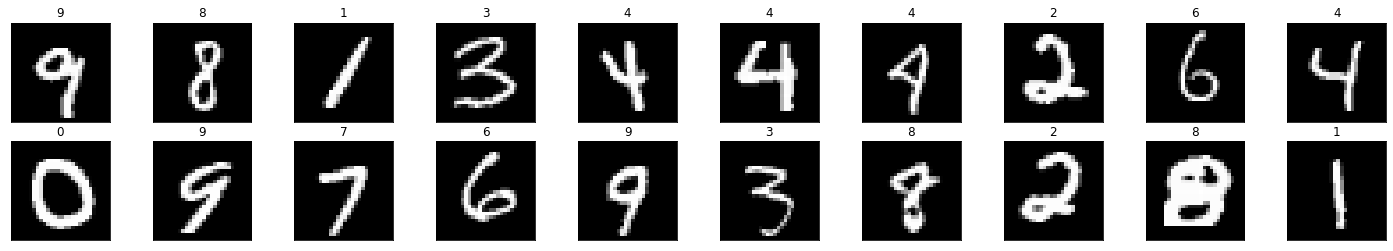

In [9]:
#Visulaize a bunch of training data
import matplotlib.pyplot as plt

#Obtain one batch of training images
images, labels  = next(iter(train_loader))

images = images.numpy()

fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  #print out the correct label for each image
  #.item() contains the value in tensor
  ax.set_title(str(labels[idx].item()))


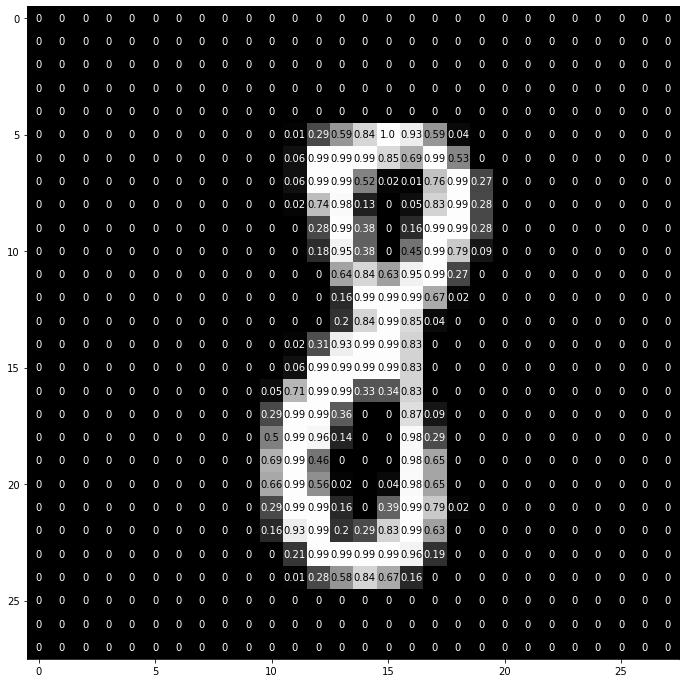

In [10]:
  
#view a image in more details

img = np.squeeze(images[1])

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.imshow(img,cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
  for y in range(height):
    val = round(img[x][y],2) if img[x][y]!=0 else 0
    ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')




In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(hidden_2, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [0]:
#Specify loss function and optimizer
criterion = nn.CrossEntropyLoss()

#specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)

In [16]:
n_epochs = 50

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################

    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.653916 	Validation Loss: 0.300690
Validation loss decreased (inf --> 0.300690).  Saving model ...
Epoch: 2 	Training Loss: 0.259646 	Validation Loss: 0.215061
Validation loss decreased (0.300690 --> 0.215061).  Saving model ...
Epoch: 3 	Training Loss: 0.189137 	Validation Loss: 0.167597
Validation loss decreased (0.215061 --> 0.167597).  Saving model ...
Epoch: 4 	Training Loss: 0.147964 	Validation Loss: 0.138594
Validation loss decreased (0.167597 --> 0.138594).  Saving model ...
Epoch: 5 	Training Loss: 0.122859 	Validation Loss: 0.122169
Validation loss decreased (0.138594 --> 0.122169).  Saving model ...
Epoch: 6 	Training Loss: 0.102586 	Validation Loss: 0.111933
Validation loss decreased (0.122169 --> 0.111933).  Saving model ...
Epoch: 7 	Training Loss: 0.087598 	Validation Loss: 0.103262
Validation loss decreased (0.111933 --> 0.103262).  Saving model ...
Epoch: 8 	Training Loss: 0.077192 	Validation Loss: 0.100591
Validation loss decreased (0.10326

In [17]:

model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [19]:
#Test with the trained network
test_loss =0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data,target in test_loader:
  output = model(data)

  loss = criterion(output,target)

  test_loss += loss.item()*data.size(0)

  _,pred = torch.max(output, 1)

  correct = np.squeeze(pred.eq(target.data.view_as(pred)))

  for i in range(len(target)):
    labels = target.data[i]
    class_correct[labels] +=correct[i].item()
    class_total[labels] +=1

#Calculate and print the average test loss
test_loss = test_loss/len(test_loader.sampler)
print("Test Loss:{:6f}\n".format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss:0.060741

Test Accuracy of     0: 99% (971/980)
Test Accuracy of     1: 99% (1125/1135)
Test Accuracy of     2: 98% (1012/1032)
Test Accuracy of     3: 97% (987/1010)
Test Accuracy of     4: 97% (959/982)
Test Accuracy of     5: 98% (876/892)
Test Accuracy of     6: 98% (943/958)
Test Accuracy of     7: 97% (1004/1028)
Test Accuracy of     8: 97% (953/974)
Test Accuracy of     9: 97% (987/1009)

Test Accuracy (Overall): 98% (9817/10000)
